In [1]:
!pip install bayesian-optimization

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm                       # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")  

In [0]:
attack_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/attack_train.csv')
attack_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/attack_test.csv')
train_vision = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/train_vision.csv')
train_vision_last = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/train_vision_last.csv')
test_vision = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/test_vision.csv')
test_vision_last = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/test_vision_last.csv')
pretrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/Pretrain.csv')
pretest = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/Pretest.csv')

pretest['Unnamed: 0']= test_vision['game_id']

In [0]:
attack_train.drop('Unnamed: 0',axis=1,inplace=True)
attack_test.drop('Unnamed: 0',axis=1,inplace=True)
pretrain.rename(columns={'Unnamed: 0':'game_id'},inplace=True)
pretest.rename(columns={'Unnamed: 0':'game_id'},inplace=True)

In [0]:
train_data=attack_train.merge(train_vision,on='game_id').merge(train_vision_last,on='game_id').merge(pretrain,on='game_id')#.merge(winner,on='game_id')
test_data=attack_test.merge(test_vision,on='game_id').merge(test_vision_last,on='game_id').merge(pretest,on='game_id')

In [0]:
train_game_id=train_data['game_id']
test_game_id=train_data['game_id']
train_data.drop('game_id',axis=1,inplace=True)
test_data.drop('game_id',axis=1,inplace=True)
X_data = train_data.drop('winner',axis=1)
y_data = train_data['winner']

In [0]:
X_train, X_test, y_train, y_test=train_test_split(X_data,y_data,random_state=0)

# 랜덤 포레스트 특성 중요도 사용
- 두 개 이상의 특성이 매우 상관관계가 높다면 하나의 특성은 매우 높은 순위를 갖지만 다른 특성 정보는 완전히 잡아내지 못하는 경우가 있다.

 1)delta_Ability                  0.016584
 2)Act_count_delta_y              0.011389
 3)mineral_x-mineral_x1           0.011366
 4)WorkerCount-WorkerCount1       0.011244
 5)Act_count_delta_x              0.011079
 6)euclid_time_NC_delta_x         0.011033
 7)delta_GetControlGroup          0.010533
 8)euclid_count_basic_delta_x     0.010257
 9)euclid_count_basic_delta_y     0.009395
10)euclid_time_NC_delta_y         0.009329
11)gas_x-gas_x1                   0.008990
12)supply-supply1                 0.008769
13)delta_Selection                0.008755
14)euclid_count_NC_delta_x        0.008507
15)euclid_count_basic_1_x         0.008473
16)euclid_count_NC_0_x            0.008184
17)euclid_count_basic_0_x         0.008144
18)euclid_count_basic_0_y         0.008133
19)euclid_count_NC_1_x            0.008029
20)euclid_time_NC_1_x             0.008008
21)euclid_count_basic_1_y         0.007996
22)1Camera-1Camera1               0.007964
23)Build_GAS-Build_GAS1           0.007946
24)Camera-C

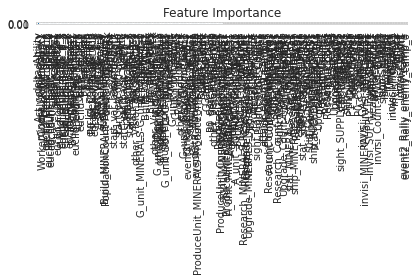

In [10]:
feat_labels= X_train.columns[:]

clf = RandomForestClassifier(n_estimators=1000,
                             random_state=0)
clf.fit(X_train,y_train)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print('%2d)%-*s %f' %(f+1,30,
                        feat_labels[indices[f]],
                        importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
              importances[indices],
              align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices],rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

In [11]:
print("훈련 세트 정확도: {:.3f}".format(clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(clf.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.639


In [0]:
best_features = X_train.columns[indices[0:102]]
train_best = train_data[best_features]
test_best= test_data[best_features]

# LGBM

In [0]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
    model = lgb.LGBMClassifier(
          num_leaves = int(num_leaves), 
          learning_rate = learning_rate, 
          n_estimators = int(n_estimators), 
          subsample = np.clip(subsample, 0, 1), 
          colsample_bytree = np.clip(colsample_bytree, 0, 1), 
          reg_alpha = reg_alpha, 
          reg_lambda = reg_lambda,
      )
    #print(len(x_train))
    #print(len(y_train))
    model.fit(x_train, y_train)
    models.append(model)
        
    pred = model.predict_proba(x_valid)[:, 1]
    true = y_valid
    score += roc_auc_score(true, pred)/n_splits
    
    # results, bad_features = permutation_importance(model=model,
    #                                            X_val=X_valid_1,
    #                                            y_val=y_valid_1,
    #                                            metric=metrics.auc,
    #                                            verbose=False)
    # print(bad_features)
    # bad.append(bad_features)


    if output == 'score':
        return score
    if output == 'model':
        return models

In [14]:
func_fixed = partial(lgb_cv, x_data=train_best, y_data=y_data, n_splits=5, output='score') 

lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 2048),#1024),
        'subsample': (0, 1),
        'colsample_bytree': (0, 1),
        'reg_alpha': (0, 10), 
        'reg_lambda': (0, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=30) #30

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.1366   |  0.0708   |  0.08152  |  1.576e+0 |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.1389   |  0.7578   |  0.009006 |  645.7    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.1373   |  0.6787   |  0.09504  |  587.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.1371   |  0.9299   |  0.09484  |  779.0    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.1394   |  0.4301   |  0.007886 |  1.574e+0 |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.1287   |  0.05497  |  0.09211  |  16.19    |  1.011e+0 |  3.481    |  45.56    |  0.7876   |
|  7        |  0.1373   |  0.8845   |  0.09154  |  1.285e+0 |  1.023e+0 |  9.548    |  49.14    |  0.0813   |
|  8      

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'],   
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=train_best, y_data=y_data, n_splits=5, output='model')

In [20]:
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/sample_submission.csv')
sample_submission.head()

,game_id,winner
0,38872,0
1,38873,0
2,38874,0
3,38875,0
4,38876,0


In [21]:
preds = []
for model in models:
    pred = model.predict(test_best)#predict_proba(test_best)[:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

sample_submission['winner'] = sample_submission['winner'] + pred
sample_submission.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/submission(1).csv')
sample_submission.head()

,game_id,winner
0,38872,1.0
1,38873,1.0
2,38874,0.0
3,38875,0.0
4,38876,1.0
